# PEL218 - Atividade 3
Processamento de Linguagem Narual (Prof. Guilherme Wachs)

Claudio Aparecido Borges Junior (RA 120122-7)

## Atividade
Implementar um modelo de linguagem 3-Grama com interpolação
* Baixa o arquivo CHAVEFolha.zip do moodle;
* A base de treinamento está na pasta **folha95**;
* Texto está nas tags <TEXT>;
* Tokenizar por palavras, transformar em minúsculo, retirar pontuação;
* Criar modelo 3-grama;
* Usar a base de teste **folha94** para medir a perplexidade por <TEXT>
* Fazer um relatório sobre os resultados:
    * Análise da base de treinamento (número de palavras, tamanho do vocabulário)
    * Extrato de maior perplexidade, menor e a distribuição de perplexidade;
    * Discutir os resultados

## Resolução
Foi escolhida a linguagem *Python* versão 3.8.5. Os arquivos folha95 foram usados para treinamento e os folha94 para teste.

In [1]:
import collections
import copy
import math
import os
import re

import matplotlib.pyplot as plt

In [2]:
folha95_path = 'CHAVEFolha/folha95/'

In [3]:
folha95_files = os.listdir(folha95_path)

### Funções para ler, preparar e tokenizar os documentos:

`read_lines:` lê cada linha do documentos na forma de *generator*

`prepare_3gram:` prepara uma linha para 3-gramas adicionando \<s\> e \</s\>

`tokeniz:` tokenização de palavras na forma de *generator* e substitui palavras OOV para \<unk\> se um vocabulario estiver presente

In [4]:
def read_lines(root_path, file_paths):
    for file_path in file_paths:
        with open(os.path.join(os.getcwd(), root_path, file_path), 'r', encoding='iso-8859-1') as f:
            it = re.finditer(r'<TEXT>(.+?)</TEXT>', f.read(), re.MULTILINE | re.DOTALL)
            for match in it:
                lines = match.groups(0)[0].splitlines()
                for line in lines:
                    if line:
                        yield line

In [5]:
def prepare_3gram(line):
    return '<s> <s> ' + line + ' </s> </s>'

In [6]:
def tokenize(string, vocabulary=None):
    it = re.finditer("<s>|<\/s>|[-a-zA-Z\xc0-\xff]+", string, flags=re.MULTILINE | re.DOTALL)
    for word in it:
        w = word.group(0).lower()
        if vocabulary:
            if w not in vocabulary and w != '<s>' and w != '</s>':
                w = '<unk>'
        yield w

### Constroi vocabulário usando a base de treinamento

In [7]:
vocabulary_pre = collections.Counter()

for line in read_lines(folha95_path, folha95_files):
    vocabulary_pre.update(tokenize(line))

Seleciona palavras que apareceram apenas 1 vez do conjunto de treinamento e as substituem para \<unk\>. Desse modo é possível treinar casos de OOV

In [8]:
# Palavras com uma ocorrência menor or igual a `oov_train_threshold` são transformadas em <unk>,
# desse modo podemos treinar <unk> na base de treinamento simulando um vocabulário definido
oov_train_threshold = 1
oov_train = [w for w, n in vocabulary_pre.items() if n <= oov_train_threshold]

In [9]:
vocabulary = copy.deepcopy(vocabulary_pre)
for w in oov_train:
    c = vocabulary_pre[w]
    del vocabulary[w]
    vocabulary['<unk>'] += c

### Estatísticas da base de treinamento

In [60]:
n_words_pre = sum(vocabulary_pre.values())
n_voc_pre = len(vocabulary_pre)

print('Número de palavras:', n_words_pre)
print('Tamanho do vocabulário:', n_voc_pre)
print('Relação do vocabulário e da quantidade de palavras:',
      '{0:.2f}'.format(n_voc_pre / n_words_pre * 100) + '%' )
for word, n in vocabulary.most_common(10):
    print('Palavra "' + word + '" ocorreu ' + str(n) + ' vezes')

Número de palavras: 17982871
Tamanho do vocabulário: 210901
Relação do vocabulário e da quantidade de palavras: 1.17%
Palavra "de" ocorreu 894061 vezes
Palavra "a" ocorreu 637392 vezes
Palavra "o" ocorreu 605855 vezes
Palavra "e" ocorreu 428649 vezes
Palavra "que" ocorreu 425298 vezes
Palavra "do" ocorreu 357115 vezes
Palavra "da" ocorreu 315598 vezes
Palavra "em" ocorreu 245729 vezes
Palavra "para" ocorreu 205622 vezes
Palavra "é" ocorreu 172255 vezes


#### Estatísticas da base após a substituição para \<unk\>

In [11]:
n_words = sum(vocabulary.values())
n_voc = len(vocabulary)

print('Número de palavras:', n_words)
print('Tamanho do vocabulário:', n_voc)
print('Quantidade de palavras consideradas <unk>:', len(oov_train))
print('Relação do vocabulário e da quantidade de palavras:',
      '{0:.2f}'.format(n_voc / n_words * 100) + '%' )

assert n_voc + len(oov_train) - 1 == n_voc_pre, 'Fail on vocabulary normalization'

Número de palavras: 17982871
Tamanho do vocabulário: 127800
Quantidade de palavras consideradas <unk>: 83102
Relação do vocabulário e da quantidade de palavras: 0.71%


### Constrói a matriz de frequência para 3-gram, 2-gram e 1-gram

São necessárias as 3 variações para poder utilizar o método da interpolação quando a probabilidade for 0

`ngrams:` retorna um generator de tamanho do ngrama

In [12]:
def generate_ngrams(tokens, n):
    t = list(tokens)
    for i in range(len(t) -n +1):
        yield t[i:i+n]

In [13]:
ngrams = collections.defaultdict(int)

for line in read_lines(folha95_path, folha95_files):
    line_marked = prepare_3gram(line)

    for i in range(1, 4):
        for w in generate_ngrams(tokenize(line_marked, vocabulary), i):
            s = ' '.join(w)
            ngrams[s] += 1

### Calcula a perplexidade da base de testes

As palavras que não estão presentes no vocabulário de treinamento são substituídas para \<unk\> e as probabilidades são interpoladas entre 3, 2 e 1 grama

In [14]:
folha94_path = 'CHAVEFolha/folha94/'

In [15]:
folha94_files = os.listdir(folha94_path)

In [16]:
# Define os hiperparâmetros lambda utilizados na interpolação
lambda_n3 = 0.5
lambda_n2 = 0.3
lambda_n1 = 0.2

p_line = []
for line in read_lines(folha94_path, folha94_files):
    line_marked = prepare_3gram(line)
    
    p = []
    for w in generate_ngrams(tokenize(line_marked, vocabulary), 3):
        n3 = ' '.join(w)
        n2 = ' '.join(w[1:3])
        n1 = w[2]
        p3 = ngrams[n3]/ngrams[n2] if ngrams[n3] else 0
        p2 = ngrams[n2]/ngrams[n1] if ngrams[n2] else 0
        p1 = ngrams[n1]/n_words if ngrams[n1] else 0
        assert p3 + p2 + p1 > 0, '{}, {}, {}, {}'.format(n3, p3, p2, p1)
        
        p.append(lambda_n3 * p3 + lambda_n2 * p2 + lambda_n1 * p1)
        
    p_line.append(p)

Calcula a perplexidade de cada linha

In [18]:
def perplexity(ps):
    prod = 1;
    for p in ps:
        prod *= 1/p
    return prod ** (1/len(ps))

pps = []
for p in p_line:
    pp = perplexity(p)
    pps.append(pp)

#### Estatísticas da perplexidade

In [19]:
pp_counter = collections.Counter(pps)
print("As 10 perplexidades que mais aparecem")
pp_counter.most_common(10)

As 10 perplexidades que mais aparecem


[(2.1165361549547326, 11141),
 (3.4013969896604017, 3413),
 (2.1686565992586515, 3043),
 (2.433739888981176, 2326),
 (inf, 2228),
 (3.9083881205362907, 1910),
 (2.575215402113554, 1767),
 (2.4216718998197733, 1512),
 (4.101446267538539, 866),
 (2.4666432938746645, 824)]

In [35]:
# Agrupa a paerpexidade em grupos
bins = {i:0 for i in range(10000)}

for pp in pps:
    for b in bins:
        if pp <= b:
            bins[b] += 1
            break;

In [45]:
print("Número de frases na base de teste", len(pps))
print("Maior perplexidade:", max(pps))
print("Menor perplexidade:", min(pps))
print("Distribuição de perplexidade:", collections.Counter(bins).most_common(20))

Número de frases na base de teste 558346
Maior perplexidade: inf
Menor perplexidade: 1.9588769365320562
Distribuição de perplexidade: [(3, 37707), (4, 19091), (5, 7957), (6, 6988), (7, 5767), (10, 5039), (8, 5008), (9, 4150), (36, 3845), (31, 3760), (30, 3738), (32, 3736), (40, 3703), (29, 3683), (38, 3676), (37, 3662), (35, 3661), (34, 3653), (39, 3636), (44, 3617)]


### Discussão dos resultados

 A quatidade de palavras únicas, chamada de vocabulário, da base de treinamento é de 210.901 palavras. Essa mesma base possui um total de 17.982.871 palavras, contabilizando portanto um vocabulário de extensão de 1.17%. Porém, para que fosse possível treinar a existência de palavras desconhecidas, isto é, palavras nunca vistas antes, todas os termos com ocorrência unitária foram substituidos para `<unk>`, estabelecendo assim um dicionário fechado implicitamente. Tais léxicos portanto formaram um outro conjunto com extensão de 127.800 ocorrências únicas ou 0.71%.

As palavras que ocorreram com maior ocorrência na base de treinamento foram artigos, preposições, conjunções, alguns poucos substantivos como presidente, folha, Brasil, país, são, paulo, rio, e também o marcador `<unk>`. Como o generero da base de treinamento é jornalístico, nomes de Estados (São Paulo e Rio de Janeiro) são notoriamente utilizados, além de termos políticos (Presidente), nomes de países (Brasil) e do próprio jornal (Folha).

A base de dados `folha94` foi utilizada para availiar a perplexidade e assim julgar a qualidade do modelo n-grama. Essa medida é o inverso da probabilidade de uma sentença ocorrer normalizada pelo número de palavras, sendo que, minimizar a perplexidade é o mesmo que aumentar a probabilidade do conjundo de teste. A perplexidade foi calculada por sentença, desse modo cada frase possui uma perplexidade distinta. A distribuição de probabilidade de perplexidade pode ser vista abaixo:

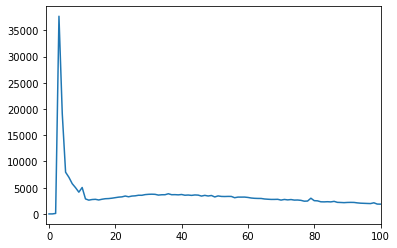

In [47]:
plt.plot(bins.keys(), bins.values())
plt.xlim(-1, 100)
plt.show()

Foram identificadas 64.848 sentenças com perplexidades menores do que 5, ou seja, 11,61% das sentençãs possuem uma perplexidade 20 vezes menor se comparada com a mesma medida exibida por Jurafsky, 2019 em seu ensaio de tri-frama com mais do que 1.5 milhões de termos do WSJ. O intervalo de perplexidade entre 2 e 3 possui a maior quantidade de linhas, totalizando 37.707 ou 6,75% do conjunto de testes.

Considerando o resultado obtido por Jurafksy, 2019 em seu ensaio com os dados do WSJ que foi encontrado uma perplexidade de 109 para tri-grama, o presente documento encontrou 373.552 linhas com perplexidade menor ou igual a 109, ou seja 66,90% dos exemplos de testes.

A menor perplexidade encontrada foi de 1,96 enquanto a maior perplexidade foi inifinita. Isso indica que houveram casos onde a probabilidade de ocorrência de uma sentença com base nos n-gramas treinados com a base de treinamento foi tão pequena que causaram estouro do limite de dados pelo Python. Esse evento ocorreu tanto utilizando as probabilidades em seu formado normal quanto utilizando base logarítmica, isto é houveram casos onde a probabilidade logarítmica foi menor do que -700. Houveram casos em que a probabilidade logarítimica foi menor do que -5443. 